# Introduction
New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise, we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

## References
- https://rpubs.com/alanyang0924/TTE

## Data Preparation
This section loads the observational dataset, performs necessary preprocessing, and prepares it for target trial emulation (TTE). We check for missing values, rename columns, and ensure correct formatting.

### Per-Protocol and ITT Definitions
We define two datasets: Per-Protocol (PP) and Intention-to-Treat (ITT). These are fundamental to understanding different estimand strategies in causal inference. ITT keeps all patients in their originally assigned treatment groups, while PP considers only those who adhere to treatment.

## Fitting the Marginal Structural Model (MSM)

We now fit a Marginal Structural Model (MSM) using inverse probability weights to adjust for confounding.

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv("../data/data_censored.csv")

print("\n📌 First few rows:")
print(data.head())

print("\n📌 Summary Statistics:")
print(data.describe())


📌 First few rows:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

📌 Summary Statistics:
               id      period   treatment          x1          x2          x3  \
count  725.000000  725.000000  725.000000  725.000000  725.000000  725.000000   
mean    49.278621    7.051034    0.467586    0.405517   -0.173552    0.486897   
std     28.119313    5.802351    0.499293    0.491331    0.997552    0.500173   
min      

### Preparing Estimands
Both `trial_pp` and `trial_itt` contain the same dataset but could later be processed differently based on the analysis approach.

We separate the estimand variables (Per-Protocol and Intention-to-Treat) because they represent different ways of analyzing the data and answering causal questions in a Target Trial Emulation (TTE). Each estimand helps address different types of biases and provides different perspectives on treatment effectiveness.

- ITT gives a "real-world" estimate of treatment effects with adherence variability.
    - It includes all participants in the treatment group they were originally assigned to, regardless of whether they actually received or adhered to the treatment.
- PP gives a "best-case scenario" estimate assuming perfect adherence.
    - It excludes patients who switched, discontinued, or otherwise deviated from the protocol.

In [2]:
# Define Per-Protocol (PP) dataset
trial_pp = {
    "data": data,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Define Intention-to-Treat (ITT) dataset
trial_itt = {
    "data": data,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

print("\n📌 PP:")
print(trial_pp['data'].head())

print("\n📌 ITT:")
print(trial_itt['data'].head())


📌 PP:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

📌 ITT:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872  

## Applying K-Means Clustering for Patient Subgroups
To enhance the Target Trial Emulation (TTE) framework, we apply K-Means clustering to segment patients into distinct groups based on their baseline characteristics. This helps refine treatment effect estimation by considering patient heterogeneity.

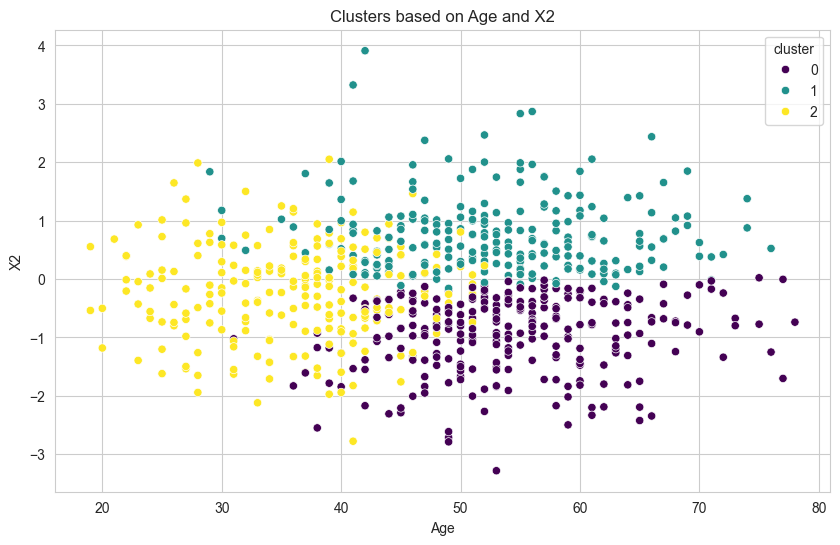

In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant baseline characteristics for clustering
features = data[['age', 'x2', 'x4']]

# Handle missing values
features = features.dropna()

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply K-Means clustering (choosing 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(features_scaled)

# Visualize Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=data['age'], y=data['x2'], hue=data['cluster'], palette='viridis')
plt.title("Clusters based on Age and X2")
plt.xlabel("Age")
plt.ylabel("X2")
plt.show()


## Calculating Weight Models and Censoring

To handle informative censoring, we estimate inverse probability of censoring weights (IPCW). This involves fitting logistic regression models for different censoring mechanisms and treatment switches, allowing us to adjust for biases in survival analysis.

In Target Trial Emulation (TTE), we use Inverse Probability Weights (IPW) to adjust for biases introduced by:

1. Treatment Switching: Some patients may switch treatments during follow-up, which can bias the estimated effect of treatment.
2. Informative Censoring: If patients drop out or become censored based on factors related to their health, it can lead to biased survival estimates.

To correct for these biases, we estimate two types of weights:
- Treatment Switching Weights: Adjust for deviations from the assigned treatment.
- Inverse Probability of Censoring Weights (IPCW): Adjust for missing outcome data due to informative censoring.

In [15]:
# Import the libraries we'll use
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import joblib
import os

# Create directory to store models
MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, name):
    """Save the logistic regression model to disk."""
    path = os.path.join(MODEL_DIR, f"{name}.pkl")
    joblib.dump(model, path)
    return path

def calculate_weights(data):
    """Fits logistic regression models for weights and saves them."""
    models = {}

    # Rename "censored" to "censor_event" if needed
    if "censor_event" not in data.columns and "censored" in data.columns:
        data = data.rename(columns={"censored": "censor_event"})

    # Ensure "prev_treatment" exists
    if "prev_treatment" not in data.columns:
        data["prev_treatment"] = data["treatment"].shift(1).fillna(0)

    # Numerator model: P(censor_event = 0 | X, Cluster)
    models["n"] = {
        "model": smf.logit("censor_event ~ x2 + cluster", data=data).fit(),
        "path": save_model(smf.logit("censor_event ~ x2 + cluster", data=data).fit(), "model_n")
    }

    # Denominator models (by previous treatment status)
    models["d0"] = {
        "model": smf.logit("censor_event ~ x2 + x1 + cluster", data=data[data["prev_treatment"] == 0]).fit(),
        "path": save_model(smf.logit("censor_event ~ x2 + x1 + cluster", data=data[data["prev_treatment"] == 0]).fit(), "model_d0")
    }

    models["d1"] = {
        "model": smf.logit("censor_event ~ x2 + x1 + cluster", data=data[data["prev_treatment"] == 1]).fit(),
        "path": save_model(smf.logit("censor_event ~ x2 + x1 + cluster", data=data[data["prev_treatment"] == 1]).fit(), "model_d1")
    }

    return models

# Compute weights for PP and ITT datasets
trial_pp_models = calculate_weights(trial_pp["data"])
trial_itt_models = calculate_weights(trial_itt["data"])

# Save weights in the dataset for further analysis
trial_pp["data"]["ipcw"] = trial_pp_models["n"]["model"].predict(trial_pp["data"])
trial_itt["data"]["ipcw"] = trial_itt_models["n"]["model"].predict(trial_itt["data"])

print("✅ Weights successfully computed and stored.")

# Print model summaries
for key, model_data in trial_pp_models.items():
    print(f"\n[{key}] Model Summary:\n", model_data["model"].summary())


Optimization terminated successfully.
         Current function value: 0.251417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255040
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255040
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.220332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.220332
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.251417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255040
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.255040
  

### Display Weight Models

In [16]:
def show_weight_models(models, name=""):
    """Display weight model summaries in a structured format."""
    print(f"\n📌 Weight Models for {name}")
    print("-" * 40)

    for key, model_data in models.items():
        print(f"\n[{key}] Model: P(censor_event = 0 | X, Cluster)")
        print(model_data["model"].summary())  # Ensure it reflects clustering
        print(f"📁 Model saved at: {model_data['path']}")  # Ensure correct path

# Display updated weight summaries
show_weight_models(trial_pp_models, "Per-Protocol (PP)")
show_weight_models(trial_itt_models, "Intention-to-Treat (ITT)")



📌 Weight Models for Per-Protocol (PP)
----------------------------------------

[n] Model: P(censor_event = 0 | X, Cluster)
                           Logit Regression Results                           
Dep. Variable:           censor_event   No. Observations:                  725
Model:                          Logit   Df Residuals:                      722
Method:                           MLE   Df Model:                            2
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.09812
Time:                        14:05:50   Log-Likelihood:                -182.28
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                 2.441e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.8228      0.367    -10.409      0.000      -4.543      -3.103
x2    

### Treatment Switching Model (PP Only)
We'll first adjust for biases introduced by patients switching treatments mid-study by doing the following:
1. Split Dataset by Previous Treatment Status
    - We need separate models for patients who were already receiving treatment and those who were not in the previous period.
2. Fit Logistic Regression Models
    - This estimates the probability of continuing treatment only based on age.
    - This etimates probability of treatment based on age, x1, and x3 to account for additional confounders.
3. Compute Stabilized Weights
    - The stabilized weight corrects for bias introduced by treatment switching.

In [17]:
# 1️⃣ Identify patients based on treatment status in the previous period
treated = data_pp[data_pp['treatment'].shift(1) == 1]
untreated = data_pp[data_pp['treatment'].shift(1) == 0]

# 2️⃣ Fitting numerator & denominator logistic regression models (NOW WITH CLUSTERING)
numerator_model_treated = smf.logit("treatment ~ age + cluster", data=treated).fit()
numerator_model_untreated = smf.logit("treatment ~ age + cluster", data=untreated).fit()
denominator_model_treated = smf.logit("treatment ~ age + x1 + x3 + cluster", data=treated).fit()
denominator_model_untreated = smf.logit("treatment ~ age + x1 + x3 + cluster", data=untreated).fit()

# 3️⃣ Predict probabilities with clustering adjustments
data_pp.loc[treated.index, 'num_prob'] = numerator_model_treated.predict(treated)
data_pp.loc[untreated.index, 'num_prob'] = numerator_model_untreated.predict(untreated)

data_pp.loc[treated.index, 'den_prob'] = denominator_model_treated.predict(treated)
data_pp.loc[untreated.index, 'den_prob'] = denominator_model_untreated.predict(untreated)

# Compute stabilized weights
data_pp['switch_weight'] = data_pp['num_prob'] / data_pp['den_prob']


Optimization terminated successfully.
         Current function value: 0.609161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.583412
         Iterations 5


### Marginal Structural Model (MSM)
Marginal Structural Models (MSM) are used to estimate causal treatment effects while adjusting for time-dependent confounding. Here, we fit an MSM to model survival probability across different treatment strategies.

In [18]:
def fit_msm(data):
    """Fits a weighted Marginal Structural Model (MSM) using IPCW weights."""
    X = data[["treatment", "cluster"]]  # Treatment and cluster as predictors
    X = sm.add_constant(X)  # Add intercept
    y = data["outcome"]  # Outcome variable
    weights = data["ipcw"]  # Inverse Probability of Censoring Weights (IPCW)

    msm = sm.WLS(y, X, weights=weights).fit()
    return msm

# Fit MSM for Per-Protocol and ITT datasets with clustering
msm_pp = fit_msm(trial_pp["data"])
msm_itt = fit_msm(trial_itt["data"])

# Print MSM Results
print("\n📌 MSM Results (Per-Protocol):\n", msm_pp.summary())
print("\n📌 MSM Results (ITT):\n", msm_itt.summary())



📌 MSM Results (Per-Protocol):
                             WLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3.982
Date:                Sat, 08 Mar 2025   Prob (F-statistic):             0.0191
Time:                        14:06:30   Log-Likelihood:                 238.41
No. Observations:                 725   AIC:                            -470.8
Df Residuals:                     722   BIC:                            -457.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.007

### Informative Censoring Model (For Both PP & ITT)
We now have to adjust for biases caused by patients dropping out for reasons related to their treatment/outcome by doing the following:
1. Fit Logistic Regression Models
    - The numerator model adjusts for x2, while the denominator model adjusts for x2 and x1, capturing more confounders.
2. Compute Inverse Probability of Censoring Weights (IPCW)
    - These weights correct for informative censoring, ensuring we correctly account for patients dropping out.

In [19]:
# 1️⃣ Fit numerator (1 - censored ~ x2 + cluster) & denominator (1 - censored ~ x2 + x1 + cluster) models
numerator_censor_model = smf.logit("censored ~ x2 + cluster", data=data_pp).fit()
denominator_censor_model = smf.logit("censored ~ x2 + x1 + cluster", data=data_pp).fit()

# 2️⃣ Predict probabilities & compute stabilized weights
data_pp['num_censor_prob'] = numerator_censor_model.predict(data_pp)
data_pp['den_censor_prob'] = denominator_censor_model.predict(data_pp)

data_pp['censor_weight'] = data_pp['num_censor_prob'] / data_pp['den_censor_prob']

# 💾 Save the dataset with weights
data_pp.to_csv("../data/data_with_weights_k_means_ver.csv", index=False)

Optimization terminated successfully.
         Current function value: 0.251417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.247597
         Iterations 8


### Visualizing Weight Distributions
After computing weights, we visualize their distributions using histograms. This helps us assess whether the estimated weights are stable or contain extreme values that may introduce bias in later steps.

#### Treatment Switching Weights
- The weights are mostly centered around 1, with values ranging from 0.76 to 1.56.
- The histogram shows some discrete peaks, possibly due to categorical covariates affecting the model.
- The mean is 1.03, and standard deviation is 0.19, suggesting moderate variation in switching weights.
- There are no extreme outliers, but the clustering around specific values might indicate that some patients have a higher probability of treatment switching than others.
#### Censoring Weights (IPCW)
- The distribution is more bimodal, with a large spike around 0.8 and another around 1.5-1.6.
- The mean is 1.10, with a higher standard deviation of 0.36 compared to switching weights.
- The first peak suggests that many patients have low censoring probability (near 0.8), while another group has higher censoring probability (~1.5-1.6).
- This could indicate informative censoring, where certain groups of patients have a higher probability of being censored.
#### Summary Statistics Review
- The quartiles confirm the observed distributions:
- Switching weights: Median ~1.01, with most values between 0.88 and 1.11.
- Censoring weights: Median ~0.81, but a wider spread (0.80 - 1.52).
- The censoring weights show more variability, which might affect the stability of the model.

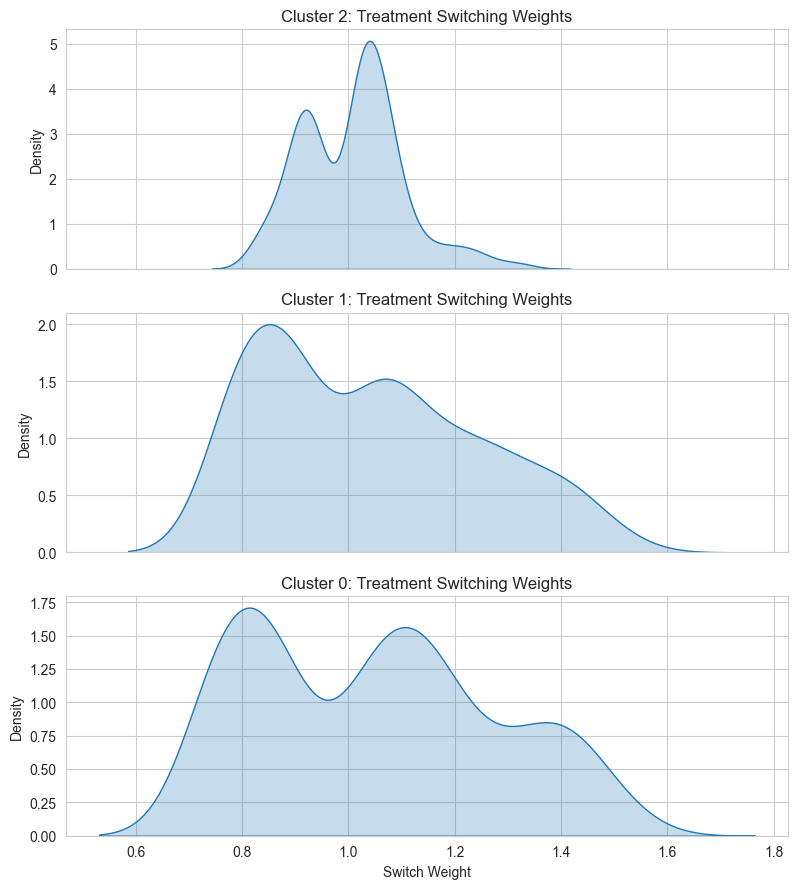

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme for cleaner visualization
sns.set_style("whitegrid")

# Get unique clusters
clusters = data_pp["cluster"].unique()
n_clusters = len(clusters)

# Create subplots
fig, axes = plt.subplots(n_clusters, 1, figsize=(8, 3 * n_clusters), sharex=True)

for i, cluster in enumerate(clusters):
    ax = axes[i] if n_clusters > 1 else axes
    sns.kdeplot(data=data_pp[data_pp["cluster"] == cluster], x="switch_weight", fill=True, ax=ax)
    ax.set_title(f"Cluster {cluster}: Treatment Switching Weights")
    ax.set_xlabel("Switch Weight")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


## Specifying the Outcome Model
First, we define the outcome model and specify any adjustment terms. In the RPubs example, x2 is used as an adjustment variable in the intention-to-treat (ITT) analysis.

In [27]:
import statsmodels.formula.api as smf

# Extract data
trial_pp_data = trial_pp["data"]
trial_itt_data = trial_itt["data"]

# Ensure assigned_treatment exists
if "assigned_treatment" not in trial_pp_data.columns:
    trial_pp_data["assigned_treatment"] = trial_pp_data["treatment"]

if "assigned_treatment" not in trial_itt_data.columns:
    trial_itt_data["assigned_treatment"] = trial_itt_data["treatment"]

# Define the outcome model for per-protocol (PP) - Removing trial_period
formula_pp = "outcome ~ assigned_treatment + period + I(period**2)"
outcome_model_pp = smf.logit(formula_pp, data=trial_pp_data).fit()

# Define the outcome model for intention-to-treat (ITT) with adjustment terms - Removing trial_period
formula_itt = "outcome ~ assigned_treatment + x2 + period + I(period**2)"
outcome_model_itt = smf.logit(formula_itt, data=trial_itt_data).fit()

# Print model summary
print(outcome_model_itt.summary())


Optimization terminated successfully.
         Current function value: 0.076045
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075594
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            4
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.03828
Time:                        14:13:26   Log-Likelihood:                -54.806
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.3592
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

## Expanding the Target Trials

We'll generate expanded trial data by:

- Creating copies of patient records for multiple time periods.
- Assigning a trial_period to each observation.

In [28]:
import pandas as pd
import numpy as np

def expand_trials(data, max_period=10):
    """
    Expands trial data by creating a sequence of target trials.
    Each patient gets multiple rows for different trial periods.
    Preserves clustering labels.
    """
    expanded_data = []
    
    for _, row in data.iterrows():
        for t in range(max_period + 1):  # Simulating follow-up time
            new_row = row.copy()
            new_row["trial_period"] = t
            new_row["followup_time"] = t  # Simulated follow-up time
            expanded_data.append(new_row)

    expanded_df = pd.DataFrame(expanded_data)

    if "cluster" in data.columns:
        expanded_df["cluster"] = expanded_df["cluster"].astype("category")

    return expanded_df

# 🔹 Expand both PP and ITT datasets while keeping clusters
trial_pp_expanded = expand_trials(trial_pp_data, max_period=10)
trial_itt_expanded = expand_trials(trial_itt_data, max_period=10)

print(trial_pp_expanded.head())
print("\n✅ Unique clusters in trial_pp_expanded:", trial_pp_expanded["cluster"].unique())


    id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   

   outcome  ...  num_prob  den_prob  switch_weight  num_censor_prob  \
0      0.0  ...       NaN       NaN            NaN         0.228589   
0      0.0  ...       NaN       NaN            NaN         0.228589   
0      0.0  ...       NaN       NaN            NaN         0.228589   
0      0.0  ...       NaN       NaN            NaN         0.228589   
0      0.0  ...       NaN       NaN            NaN         0.228589   

   den_censor_prob  censor_weight  assigned_treatment  cluster  trial_period  \
0          0.16211       1.410083         

## Loading or Sampling from Expanded Data
For large datasets, it's necessary to sample from the expanded data to control memory usage. The RPubs example samples control patients with outcome == 0.

In [29]:
def sample_expanded_data(data, seed=1234, p_control=0.5):
    """
    Samples expanded data while ensuring balance across clusters.
    This reduces memory usage while keeping all outcome=1 observations.
    """
    np.random.seed(seed)
    
    sampled_data = []

    # 🔹 Sample control group separately within each cluster
    for cluster_id in data["cluster"].unique():
        cluster_data = data[data["cluster"] == cluster_id]
        
        control_sample = cluster_data[cluster_data["outcome"] == 0].sample(
            frac=p_control, random_state=seed, replace=False
        )
        
        treated_sample = cluster_data[cluster_data["outcome"] == 1]  # Keep all treated patients
        
        sampled_data.append(pd.concat([control_sample, treated_sample]))

    # ✅ Concatenate all cluster-wise samples
    sampled_df = pd.concat(sampled_data).reset_index(drop=True)

    return sampled_df

# 🔹 Sample ITT dataset while preserving cluster distributions
trial_itt_sampled = sample_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)

# ✅ Debug: Check sampled data
print(trial_itt_sampled.head())
print("\n✅ Sampled Data Cluster Distribution:\n", trial_itt_sampled["cluster"].value_counts(normalize=True))


     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0   1.0     5.0        1.0  0.0 -0.057482  0.0  0.734203  41.0  0.500000   
1  63.0     0.0        1.0  0.0 -0.143601  0.0  1.825085  37.0  0.166667   
2  33.0    19.0        1.0  0.0 -0.934327  0.0  0.867731  48.0  1.083333   
3   6.0     3.0        1.0  1.0 -1.601660  1.0  0.003098  37.0  0.166667   
4   9.0     0.0        1.0  0.0 -0.153579  1.0  2.018846  30.0 -0.416667   

   outcome  ...  num_prob  den_prob  switch_weight  num_censor_prob  \
0      0.0  ...  0.784717  0.744243       1.054382         0.156559   
1      0.0  ...  0.550294  0.498337       1.104260         0.152190   
2      0.0  ...  0.823289  0.789802       1.042399         0.116622   
3      0.0  ...  0.760081  0.827607       0.918409         0.092443   
4      0.0  ...  0.712529  0.691358       1.030623         0.151691   

   den_censor_prob  censor_weight  assigned_treatment  cluster  trial_period  \
0         0.191192       0.818860   

## Fitting the Marginal Structural Model (MSM)

We now fit a Marginal Structural Model (MSM) using inverse probability weights to adjust for confounding.

In [34]:
import warnings
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Suppress only ValueWarnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

def fit_msm(data, weight_cols=["switch_weight", "censor_weight"]):
    """
    Fits a logistic regression MSM using inverse probability weighting.
    Handles singular matrix errors by filtering small clusters and using regularization.
    """
    data = data.copy()
    data["w"] = data[weight_cols].product(axis=1)  # Compute final weights

    # ✅ Drop clusters with very small size
    min_cluster_size = 5  # Adjust based on dataset
    valid_clusters = data["cluster"].value_counts()
    valid_clusters = valid_clusters[valid_clusters > min_cluster_size].index
    data = data[data["cluster"].isin(valid_clusters)]

    if data["outcome"].nunique() == 1:  # If only 0s or 1s exist, model cannot fit
        print("⚠️ Skipping: Outcome is constant within this cluster.")
        return None

    # ✅ Adjusted formula with clustering
    formula = "outcome ~ assigned_treatment + x2 + period + I(period**2) + C(cluster)"

    try:
        msm_model = smf.logit(formula, data, weights=data["w"]).fit(method="lbfgs")  # Use regularization
        return msm_model
    except np.linalg.LinAlgError:
        print("⚠️ Singular matrix detected. Skipping model for this subset.")
        return None

# 🔹 Fit MSM on ITT sampled data with clustering adjustment
msm_itt = fit_msm(trial_itt_sampled)

# ✅ Print Model Summary
if msm_itt:
    print("\n📌 MSM Model (ITT) Adjusted for Clustering:\n", msm_itt.summary())

# 🔹 Stratified MSM models per cluster
for cluster_id in sorted(trial_itt_sampled["cluster"].unique()):
    subset_data = trial_itt_sampled[trial_itt_sampled["cluster"] == cluster_id]
    
    if len(subset_data) > 10:  # Avoid fitting models on tiny clusters
        msm_cluster = fit_msm(subset_data)
        if msm_cluster:
            print(f"\n📌 MSM Model (ITT) for Cluster {cluster_id}:\n", msm_cluster.summary())

warnings.resetwarnings()



📌 MSM Model (ITT) Adjusted for Clustering:
                            Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 4049
Model:                          Logit   Df Residuals:                     4042
Method:                           MLE   Df Model:                            6
Date:                Sat, 08 Mar 2025   Pseudo R-squ.:                 0.02376
Time:                        14:15:42   Log-Likelihood:                -531.01
converged:                      False   LL-Null:                       -543.94
Covariance Type:            nonrobust   LLR p-value:                 0.0002381
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.2859      0.267     -8.575      0.000      -2.808      -1.763
C(cluster)[T.1.0]     -0.8899      0.316     -2.814      0.005

## Survival Prediction & Insights

Finally, we use the fitted model to estimate survival probabilities over time.

This graph visualizes survival differences stratified by clusters formed using age, x2, and x4.

Cluster 0 (blue) shows the highest survival difference early on, peaking around 0.07, then declining steadily.
Cluster 1 (orange) follows a similar pattern but with slightly lower survival benefits than Cluster 0.
Cluster 2 (green) starts with the lowest survival difference, maintaining a smaller but consistent benefit over time.
All clusters show a peak around 5–7 time units before survival benefits decline. The confidence intervals (shaded areas) suggest some uncertainty, but overall trends indicate that treatment effects vary across patient clusters. This suggests that baseline characteristics significantly influence survival outcomes, reinforcing the importance of stratified analysis.

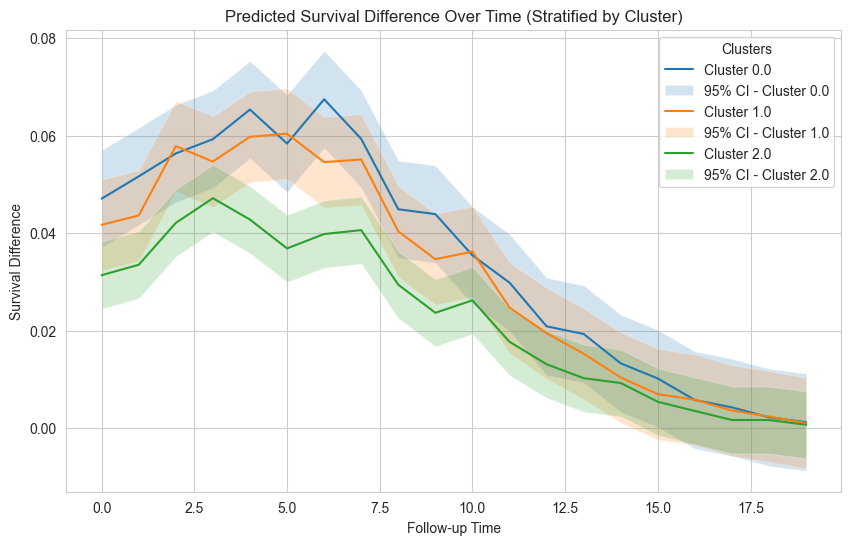

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def predict_survival(model, data, times=np.arange(0, 11)):
    """
    Predicts survival probabilities for treatment groups over follow-up time.
    Now includes clustering effects and 95% confidence intervals.
    """
    if "cluster" not in data.columns:
        raise ValueError("❌ ERROR: 'cluster' column is missing in the dataset.")

    clusters = sorted(data["cluster"].unique())
    plt.figure(figsize=(10, 6))

    for cluster in clusters:
        subset_data = data[data["cluster"] == cluster].copy()

        if len(subset_data) < 10:  # Skip small clusters
            print(f"⚠️ Skipping Cluster {cluster}: Too few observations.")
            continue

        subset_control = subset_data.copy()
        subset_control["assigned_treatment"] = 0  # Control group

        subset_treated = subset_data.copy()
        subset_treated["assigned_treatment"] = 1  # Treated group

        preds_control = model.predict(subset_control)
        preds_treated = model.predict(subset_treated)

        # Compute survival probabilities (1 - predicted risk)
        survival_control = 1 - preds_control.groupby(subset_control["period"]).mean()
        survival_treated = 1 - preds_treated.groupby(subset_treated["period"]).mean()

        # Compute survival difference
        survival_diff = survival_treated - survival_control

        # Compute confidence intervals (using standard deviation)
        ci = 1.96 * np.std(survival_diff) / np.sqrt(len(survival_diff))

        # Plot survival difference for this cluster
        sns.lineplot(x=survival_diff.index, y=survival_diff, label=f"Cluster {cluster}")

        # Fill confidence interval area
        plt.fill_between(
            survival_diff.index,
            survival_diff - ci,
            survival_diff + ci,
            alpha=0.2,
            label=f"95% CI - Cluster {cluster}"
        )

    # Add labels and legend
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("Predicted Survival Difference Over Time (Stratified by Cluster)")
    plt.legend(title="Clusters")
    plt.grid(True)
    plt.show()

# Apply prediction
predict_survival(msm_itt, trial_itt_sampled)


## Comparing the Original and Clustered Methods

The original survival prediction method analyzed survival differences across all patients without accounting for inherent differences in baseline characteristics. This provided a **generalized survival trend**, showing how treatment influenced the overall population but lacked granularity in subgroup behaviors.  

By introducing **clustering based on age, x2, and x4**, the analysis now accounts for **heterogeneity among patients**, revealing distinct survival patterns across subgroups. This method allows for **more personalized insights**—for example, Cluster 0 experienced the highest initial survival difference, while Cluster 2 consistently showed the lowest.  

#### Benefits
- **Original Method:** Useful for getting an **overall survival effect**, making it easier to see broad trends and treatment effectiveness at a population level.  
- **Clustered Method:** More **refined and individualized**, highlighting variations in treatment effects that may be overlooked in a one-size-fits-all approach. This is particularly valuable in **precision medicine**, risk stratification, and targeted interventions.  

#### Impact on Data Interpretation
The clustered method **reduces bias** by ensuring comparisons are made among **similar patient groups** rather than across a mixed population. This makes the results **more interpretable and actionable**, as different clusters may require **different treatment strategies**. While the original method provided a high-level view, **stratification reveals nuanced differences**, making it a **stronger approach for understanding real-world patient responses**.